In [154]:
import pickle
import os
import tarfile
import urllib
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [155]:
def load_data(filename):

    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        X = X.reshape(10000,3072)
        y = datadict[b'labels']
        y = np.array(y)
        return X, y

def get_data(arr):
    X = []
    y = []
    for i in arr:
        a,b=load_data(i)
        X.append(a)
        y.append(b)
        del a,b
    X = np.concatenate(X)
    y = np.concatenate(y)

    X = X/255
    return X, y

def load_data_test(filename):
    
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X_test = np.asarray(datadict[b'data'])
        X_test = X_test.reshape(10000,3072)
        y_test = np.asarray(datadict[b'labels'])
        return X_test/255, y_test


In [156]:
URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
FILE = 'cifar-10-python.tar.gz'

if not os.path.isfile(FILE):
  urllib.request.urlretrieve(URL, FILE)

file = tarfile.open(FILE)
print(file.getnames())
file.extractall('./')
file.close

path = ["./cifar-10-batches-py/data_batch_1","./cifar-10-batches-py/data_batch_2","./cifar-10-batches-py/data_batch_3","./cifar-10-batches-py/data_batch_4","./cifar-10-batches-py/data_batch_5"]
X, y = get_data(path)

X_test, y_test = load_data_test("./cifar-10-batches-py/test_batch")

X = X.T

X_test = X_test.T

['cifar-10-batches-py', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/readme.html', 'cifar-10-batches-py/test_batch', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/batches.meta', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_5', 'cifar-10-batches-py/data_batch_1']


In [157]:
def relu(v):
    return np.maximum(v, 0)

def softmax(v):
    activation = np.exp(v) / sum(np.exp(v))
    return activation

def derrelu(v):
    return v > 0

def ohe(y):
    ym = np.zeros((y.size, y.max() + 1))
    ym[np.arange(y.size), y] = 1
    ym = ym.T
    return ym

In [158]:
def params():
    weights1 = np.random.rand(100, 3072)-0.5
    biases1 = np.random.rand(100, 1)-0.5
    weights2 = np.random.rand(10, 100)-0.5
    biases2 = np.random.rand(10, 1)-0.5
    return weights1, biases1, weights2, biases2

def predictions(activation2):
    return np.argmax(activation2, 0)

def accuracy(predictions, y):
    return np.sum(predictions == y) / y.size

In [159]:
def forward_propogation(weights1, biases1, weights2, biases2, X):
    v1 = weights1.dot(X) + biases1
    activation1 = relu(v1)
    v2 = weights2.dot(activation1) + biases2
    activation2 = softmax(v2)
    return v1, activation1, v2, activation2

def backward_propogation(v1, activation1, v2, activation2, weights1, biases1, weights2, biases2, X, y, alpha, s):
    ym = ohe(y)
    derv2 = activation2 - ym
    derweights2 = (1 / s) * derv2.dot(activation1.T)
    derbiases2 = (1 / s) * np.sum(derv2)
    derv1 = weights2.T.dot(derv2) * derrelu(v1)
    derweights1 = (1 / s) * derv1.dot(X.T)
    derbiases1 = (1 / s) * np.sum(derv1)
    weights1 = weights1 - alpha * derweights1
    biases1 = biases1 - alpha * derbiases1    
    weights2 = weights2 - alpha * derweights2  
    biases2 = biases2 - alpha * derbiases2    
    return weights1, biases1, weights2, biases2

In [160]:
def gradient_descent(X, y, alpha, s, epochs):
    weights1, biases1, weights2, biases2 = params()
    for i in range(epochs):
      v1, activation1, v2, activation2 = forward_propogation(weights1, biases1, weights2, biases2, X)
      weights1, biases1, weights2, biases2 = backward_propogation(v1, activation1, v2, activation2, weights1, biases1, weights2, biases2, X, y, alpha, s)
      if i % 10 == 0:
        preds = predictions(activation2)
        print("Epoch: %d  Acuraccy: %f" % (i, accuracy(preds, y)))
    return weights1, biases1, weights2, biases2

In [161]:
weights1, biases1, weights2, biases2 = gradient_descent(X, y, 0.1, 50000, 25000)

Epoch: 0  Acuraccy: 0.100700


0.1097


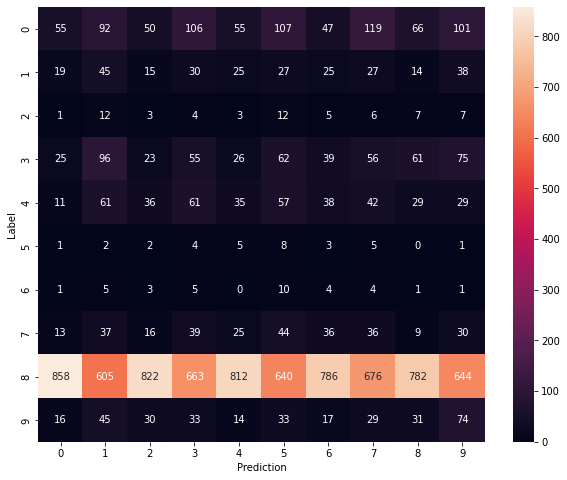

In [162]:
def make_predictions(X, weights1, biases1, weights2, biases2):
    _, _, _, activation2 = forward_propogation(weights1, biases1, weights2, biases2, X)
    preds = predictions(activation2)
    return preds


make_predictions = make_predictions(X_test, weights1, biases1, weights2, biases2)
print(accuracy(make_predictions, y_test))

confusion_mtx = tf.math.confusion_matrix(make_predictions, y_test) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt = 'g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()